# Task1: 基于自动微分的手写数字识别
## 引入相关库

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

## 设置超参数

In [2]:
input_size = 784
hidden_size = 100
label_num = 10

learning_rate = 0.01
epoches = 10
batch_size = 128

## 随机初始化模型参数

- np.random.randn(d0, d1, ..., dn) [Doc](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)

    - 生成服从标准正态分布的随机数
    - Params: d0, d1, ..., dn: int，指示生成的矩阵每一维度大小
    - Returns: ndarray

- np.zeros(shape, dtype=float) [Doc](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html#)

    - 生成全零矩阵
    - Parmas: shape: int或tuple，指示生成的矩阵大小，如(2, 3)或2
    - Returns: ndarray

In [3]:
Wh = np.random.randn(input_size, hidden_size) / 10
bh = np.zeros(hidden_size, )
Wo = np.random.randn(hidden_size, label_num) / 5
bo = np.zeros(label_num, )

## 把np.ndarray转换为torch.Tensor

- torch.FloatTensor(data) [Doc](https://pytorch.org/docs/stable/generated/torch.tensor.html)

    - 从已有数据构建torch Tensor
    - Params: data: list或tuple或ndarray，已有数据
    - Returns: torch.Tensor

- torch.Tensor.requires_grad [Doc](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html)

    - 属性，表示tensor是否加入计算图，设置为True即表示需要反向累积梯度

In [4]:
Wh = torch.FloatTensor(Wh)
bh = torch.FloatTensor(bh)
Wo = torch.FloatTensor(Wo)
bo = torch.FloatTensor(bo)

Wh.requires_grad = True
bh.requires_grad = True
Wo.requires_grad = True
bo.requires_grad = True

## 加载数据集

- 自动下载MNIST数据集到./MNIST路径

In [5]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root="./MNIST", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./MNIST", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)

## 定义正向预测

- 函数功能

    - 实现模型的正向传播
    - 模型定义：

        - $h = \sigma(W_h x + b_h)$
        - $o = W_o h + b_o$

- Params: 

    - x: 输入矩阵，torch.Tensor, shape = [batch_size, input_size]
    - Wh: 隐藏层参数矩阵，torch.Tensor, shape = [input_size, hidden_size]
    - bh: 隐藏层偏置矩阵，torch.Tensor, shape = [hidden_size]
    - Wo: 输出层参数矩阵，torch.Tensor, shape = [hidden_size, label_num]
    - bo: 输出层偏置矩阵，torch.Tensor, shape = [label_num]

- Return: 

    - o: 输出矩阵，torch.Tensor, shape = [batch_size, label_num]

- API参考

    - torch.mm(input, mat2) [Doc](https://pytorch.org/docs/stable/generated/torch.mm.html)

        - 执行标准数学矩阵乘法
        - Params: 

            - input: 输入矩阵1，torch.Tensor, shape = [n, m]
            - mat2: 输入矩阵2，torch.Tensor, shape = [m, p]
        
        - Return:

            - out: 输出矩阵，torch.Tensor, shape = [n, p]

    - torch.sigmoid(input) [Doc](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)

        - 对输入的每一位执行sigmoid函数运算
        - Param: input: torch.Tensor
        - Return: torch.Tensor, shape = input.shape

In [6]:
def forward(x, Wh, bh, Wo, bo):
    
    # TODO: 根据上述函数描述，利用给定的API实现模型正向预测计算
    h = torch.sigmoid(torch.mm(x, Wh) + bh)
    o = torch.mm(h, Wo) + bo
    return o

## 定义反向过程（梯度计算）

- 函数功能

    - 根据模型预测o和真实标签y，实现对Wh, bh, Wo, bo参数矩阵的损失及反向传播梯度计算
    - 过程定义：

        - $\tilde{o}_j = \frac{\exp(o_j)}{\sum_{l=1}^{10} \exp(o_l)}$
        - $\ell(\tilde{o}, y) = -\sum_{j=1}^{10} y_j \cdot \ln \tilde{o}_j$

- Params:

    - o: 预测输出矩阵，torch.Tensor, shape = [batch_size, label_num]
    - y: 真实标签矩阵，torch.Tensor, shape = [batch_size]
    - Wh: 隐藏层参数矩阵，torch.Tensor, shape = [input_size, hidden_size]
    - bh: 隐藏层偏置矩阵，torch.Tensor, shape = [hidden_size]
    - Wo: 输出层参数矩阵，torch.Tensor, shape = [hidden_size, label_num]
    - bo: 输出层偏置矩阵，torch.Tensor, shape = [label_num]

- Return:

    - dWh, dbh, dWo, dbo: torch.Tensor, 与原矩阵等大的梯度矩阵

- API参考

    - torch.nn.CrossEntropyLoss() [Doc](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
        
        - 对象，可根据给定的模型输出o与真实标签y计算交叉熵损失，内置了Softmax步骤
        - loss.backward(): loss可通过调用CrossEntropyLoss计算获得；对loss执行backward()会为计算图中涉及的tensor反向计算梯度，累积到tensor.grad上

In [7]:
loss_func = torch.nn.CrossEntropyLoss()


def calc_grad(o, y, Wh, bh, Wo, bo):
    loss = loss_func(o, y)
    loss.backward()
    return Wh.grad, bh.grad, Wo.grad, bo.grad

## 定义训练过程

- 函数功能

    - 在数据集dataloader上训练参数Wh, bh, Wo, bo
    - 过程定义：

        - forward, backward获取参数梯度
        - 根据SGD步骤更新参数矩阵，如Wh = Wh - lr * dWh

- Params:

    - dataloader: 数据集读取对象，可以迭代地返回(x, y)数据对
    - lr: 学习率，float
    - Wh, bh, Wo, bo: 初始参数矩阵

- Return: 

    - Wh, bh, Wo, bo: 更新后的参数矩阵

In [8]:
def train(dataloader, lr, Wh, bh, Wo, bo):
    for x, y in dataloader:
        # reshape x from [batch_size, 28, 28] to [batch_size, 784]
        x = x.reshape(-1, 28 * 28)
        
        # TODO: 根据上述函数描述，利用已经实现好的forward, calc_grad函数，获取参数梯度，实现参数的SGD更新
        o = forward(x, Wh, bh, Wo, bo)
        Wh_grad, bh_grad, Wo_grad, bo_grad = calc_grad(o, y, Wh, bh, Wo, bo)
        Wh.data = Wh.data - lr * Wh_grad
        bh.data = bh.data - lr * bh_grad
        Wo.data = Wo.data - lr * Wo_grad
        bo.data = bo.data - lr * bo_grad
        
    return Wh, bh, Wo, bo

## 定义测试过程

- 函数功能

    - 在数据集dataloader上测试参数Wh, bh, Wo, bo参数构成模型的性能
    - 过程定义：

        - forward获取输出矩阵o，shape = [batch_size, label_num]
        - 获取模型预测标签prediction，即矩阵o每一行的最大元素下标，shape = [batch_size]
        - 统计预测正确的样本数correct与总样本数total

- Params:

    - dataloader: 数据集读取对象，可以迭代地返回(x, y)数据对
    - Wh, bh, Wo, bo: 参数矩阵

- Return: 

    - accuracy: 数据集上的预测准确率，float

- API参考

    - torch.argmax(input, dim) [Doc](https://pytorch.org/docs/stable/generated/torch.argmax.html)

        - 获取矩阵某一维度最大元素的下标
        - Params:

            - input: 计算基于的tensor, torch.Tensor
            - dim: 希望按哪个维度求max下标, int

        - Return: 下标矩阵

In [9]:
def predict(x, Wh, bh, Wo, bo):
    # TODO: 根据上述函数描述，利用已经实现好的forward函数和给定的参考API，实现模型的预测
    o = forward(x, Wh, bh, Wo, bo)
    prediction = torch.argmax(o, dim=1)
    return prediction


def test(dataloader, Wh, bh, Wo, bo):
    correct = 0
    total = 0
    for x, y in dataloader:
        # reshape x from [batch_size, 28, 28] to [batch_size, 784]
        x = x.reshape(-1, 28 * 28)
        
        # forward & predict
        prediction = predict(x, Wh, bh, Wo, bo)

        # TODO: 根据上述函数描述，实现模型的预测准确率统计
        correct += torch.sum(prediction == y).item()
        total += y.shape[0]
    return correct / total

## 完成训练、测试、保存参数

In [10]:
for epoch in range(1, epoches + 1):
    Wh, bh, Wo, bo = train(train_loader, learning_rate, Wh, bh, Wo, bo)
    if epoch % 2 == 0:
        train_accuracy = test(train_loader, Wh, bh, Wo, bo)
        test_accuracy = test(test_loader, Wh, bh, Wo, bo)
        print("Epoch", epoch, "Train Accuracy =", train_accuracy)
        print("Epoch", epoch, "Test Accuracy =", test_accuracy)

torch.save(Wh, "./Wh.pth")
torch.save(Wo, "./Wo.pth")
torch.save(bh, "./bh.pth")
torch.save(bo, "./bo.pth")

Epoch 2 Train Accuracy = 0.9075687767094017
Epoch 2 Test Accuracy = 0.9058493589743589
Epoch 4 Train Accuracy = 0.9248798076923077
Epoch 4 Test Accuracy = 0.9178685897435898
Epoch 6 Train Accuracy = 0.9130775908119658
Epoch 6 Test Accuracy = 0.9042467948717948
Epoch 8 Train Accuracy = 0.9198551014957265
Epoch 8 Test Accuracy = 0.9128605769230769
Epoch 10 Train Accuracy = 0.919921875
Epoch 10 Test Accuracy = 0.9125600961538461


## 样本预测可视化

In [11]:
from matplotlib import pyplot as plt

def visualize(imgs, true_labels, pred_labels):
    fig = plt.figure(figsize=(8, 8))
    for idx, (img, true_label, pred_label) in enumerate(zip(imgs, true_labels, pred_labels)):
        ax = fig.add_subplot(4, 5, idx + 1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'true label: {true_label.item()}\npred label: {pred_label.item()}')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

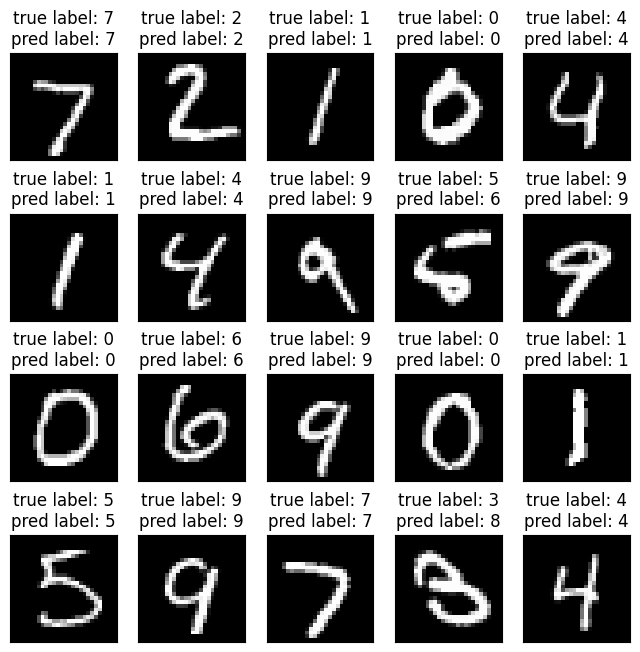

In [12]:
# take out the first 20 samples in test set
x, y = next(iter(test_loader))
x, y = x[:20], y[:20]

# forward
x = x.reshape(-1, 28 * 28)
pred = predict(x, Wh, bh, Wo, bo)

# visualize
x = x.reshape(-1, 28, 28)
visualize(x, y, pred)